# Activation Functions: ReLU and GELU

This notebook derives the forward and backward passes for activation functions used in transformers.

---

## Formulas and Theorems Used

### Definitions

| Name | Formula | Used For |
|------|---------|----------|
| ReLU | $\text{ReLU}(x) = \max(0, x)$ | Forward pass |
| GELU | $\text{GELU}(x) = x \cdot \Phi(x)$ | Forward pass |
| Normal CDF | $\Phi(x) = \frac{1}{2}\left[1 + \text{erf}\left(\frac{x}{\sqrt{2}}\right)\right]$ | GELU definition |
| Error function | $\text{erf}(x) = \frac{2}{\sqrt{\pi}}\int_0^x e^{-t^2}dt$ | Normal CDF |
| Tanh | $\tanh(x) = \frac{e^x - e^{-x}}{e^x + e^{-x}}$ | GELU approximation |

### Calculus Rules

| Rule | Formula | Used For |
|------|---------|----------|
| Chain Rule | $\frac{d}{dx}f(g(x)) = f'(g(x)) \cdot g'(x)$ | All backward passes |
| Product Rule | $\frac{d}{dx}[f(x) \cdot g(x)] = f'(x)g(x) + f(x)g'(x)$ | GELU backward |
| Tanh derivative | $\frac{d}{dx}\tanh(x) = 1 - \tanh^2(x) = \text{sech}^2(x)$ | GELU backward |

### Key GELU Formulas

| Formula | Expression |
|---------|------------|
| GELU (tanh approx) | $\text{GELU}(x) = \frac{x}{2}\left[1 + \tanh\left(\sqrt{\frac{2}{\pi}}\left(x + 0.044715 x^3\right)\right)\right]$ |
| GELU derivative | $\text{GELU}'(x) = \frac{1}{2}(1 + \tanh u) + \frac{x}{2}(1 - \tanh^2 u) \cdot \frac{du}{dx}$ |
| where | $u = \sqrt{\frac{2}{\pi}}(x + 0.044715x^3)$, $\frac{du}{dx} = \sqrt{\frac{2}{\pi}}(1 + 0.134145x^2)$ |

## Glossary of Terms

| Term | Definition |
|------|------------|
| **Activation function** | A nonlinear function applied element-wise to layer outputs. Without activations, a neural network would just be a linear transformation, unable to learn complex patterns. |
| **Nonlinearity** | A function where $f(ax + by) \neq af(x) + bf(y)$. Essential for neural networks to approximate arbitrary functions. |
| **Forward pass** | Computing the output of a layer or network given an input. Propagates data from input to output. |
| **Backward pass** | Computing gradients of the loss with respect to parameters. Propagates error signals from output back to input (backpropagation). |
| **Gradient** | The derivative of the loss function with respect to a parameter. Points in the direction of steepest increase; we move opposite to update weights. |
| **Upstream gradient** | $\frac{\partial L}{\partial y}$ — the gradient flowing backward from later layers in the network. We multiply this by the local gradient to get the gradient for earlier layers. |
| **Vanishing gradient** | When gradients become very small (near zero) as they propagate backward through many layers, making early layers learn very slowly or not at all. |
| **Dead neuron** | A neuron (in ReLU networks) that always outputs zero because its input is always negative. Since ReLU'(x) = 0 for x < 0, the gradient is always zero and the neuron never updates. |
| **CDF (Cumulative Distribution Function)** | $\Phi(x) = P(X \leq x)$ — the probability that a random variable is less than or equal to $x$. For GELU, we use the standard normal CDF. |
| **Error function (erf)** | A special function related to the normal CDF: $\Phi(x) = \frac{1}{2}[1 + \text{erf}(x/\sqrt{2})]$. Has no closed-form solution, requires numerical computation. |
| **Numerical stability** | Implementing formulas to avoid overflow/underflow or loss of precision. E.g., using $x - \max(x)$ before $\exp$ to prevent overflow. |

---
## Prerequisites: Math Skills Review

### The Chain Rule (Critical for Backpropagation)

The chain rule tells us how to differentiate composite functions. If $y = f(g(x))$, then:

$$\frac{dy}{dx} = \frac{df}{dg} \cdot \frac{dg}{dx}$$

**Intuition**: If $g$ changes by a small amount $\Delta g$, and $f$ changes by $\Delta f$ in response, then the total change in $y$ when $x$ changes is the product of these rates.

**Example**: Let $y = (3x + 2)^2$. Here $g(x) = 3x + 2$ and $f(g) = g^2$.
- $\frac{dg}{dx} = 3$
- $\frac{df}{dg} = 2g$
- $\frac{dy}{dx} = 2g \cdot 3 = 6(3x + 2)$

### The Product Rule

For $y = f(x) \cdot g(x)$:

$$\frac{dy}{dx} = f'(x) \cdot g(x) + f(x) \cdot g'(x)$$

**Intuition**: Both $f$ and $g$ are changing. The total change in the product comes from: (change in $f$) × (value of $g$) + (value of $f$) × (change in $g$).

**Example**: Let $y = x \cdot \sin(x)$.
- $f(x) = x$, $f'(x) = 1$
- $g(x) = \sin(x)$, $g'(x) = \cos(x)$
- $\frac{dy}{dx} = 1 \cdot \sin(x) + x \cdot \cos(x) = \sin(x) + x\cos(x)$

### Hyperbolic Functions

The hyperbolic tangent (tanh) is defined as:

$$\tanh(x) = \frac{e^x - e^{-x}}{e^x + e^{-x}} = \frac{\sinh(x)}{\cosh(x)}$$

**Key properties**:
- Range: $(-1, 1)$ — always between -1 and 1
- $\tanh(0) = 0$
- Odd function: $\tanh(-x) = -\tanh(x)$
- Asymptotes: $\lim_{x \to \infty} \tanh(x) = 1$, $\lim_{x \to -\infty} \tanh(x) = -1$

**Derivative** (important!):
$$\frac{d}{dx}\tanh(x) = 1 - \tanh^2(x) = \text{sech}^2(x)$$

This is called "sech squared" (hyperbolic secant squared). The key insight: **if you already computed $\tanh(x)$, you can get the derivative cheaply** by just squaring and subtracting from 1.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '..')
from ai_comps.activations import relu, relu_backward, gelu, gelu_backward

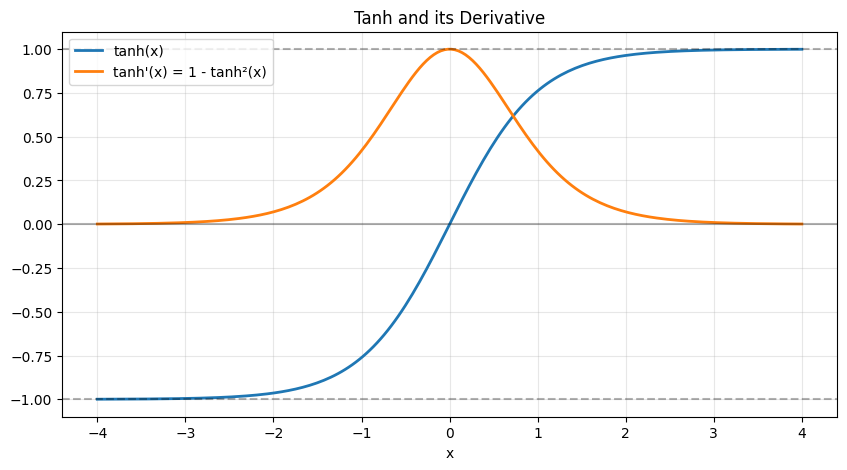

Notice: tanh'(x) is largest at x=0 and decays to 0 for large |x|
This is why tanh has 'vanishing gradient' problems for large inputs


In [3]:
# Visualize tanh and its derivative
x = np.linspace(-4, 4, 200)
tanh_x = np.tanh(x)
tanh_deriv = 1 - tanh_x**2  # This is sech^2(x)

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(x, tanh_x, label='tanh(x)', linewidth=2)
ax.plot(x, tanh_deriv, label="tanh'(x) = 1 - tanh²(x)", linewidth=2)
ax.axhline(y=0, color='k', linestyle='-', alpha=0.3)
ax.axhline(y=1, color='k', linestyle='--', alpha=0.3)
ax.axhline(y=-1, color='k', linestyle='--', alpha=0.3)
ax.set_xlabel('x')
ax.legend()
ax.set_title('Tanh and its Derivative')
ax.grid(True, alpha=0.3)
plt.show()

print("Notice: tanh'(x) is largest at x=0 and decays to 0 for large |x|")
print("This is why tanh has 'vanishing gradient' problems for large inputs")

### The Normal Distribution and Its CDF

The standard normal distribution has PDF:
$$\phi(x) = \frac{1}{\sqrt{2\pi}} e^{-x^2/2}$$

The CDF (cumulative distribution function) is:
$$\Phi(x) = P(X \leq x) = \int_{-\infty}^{x} \phi(t) \, dt$$

**Key properties**:
- $\Phi(-\infty) = 0$, $\Phi(\infty) = 1$
- $\Phi(0) = 0.5$
- $\Phi(-x) = 1 - \Phi(x)$ (symmetry)

The CDF tells us "what fraction of a normal distribution is less than $x$". This is the probability interpretation behind GELU.

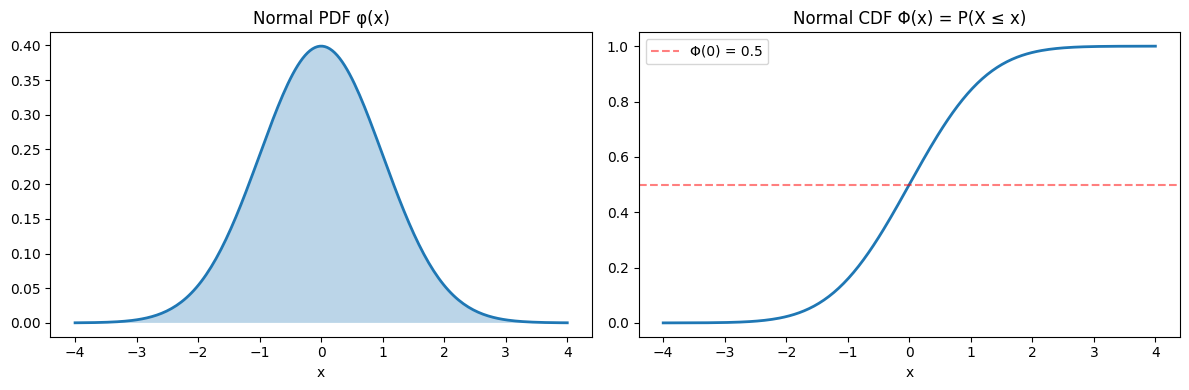

Φ(-2) = 0.0228  (only 2.3% of normal is below -2)
Φ(0)  = 0.5000  (exactly half)
Φ(2)  = 0.9772  (97.7% is below 2)


In [4]:
# Visualize the normal CDF
from scipy.stats import norm

x = np.linspace(-4, 4, 200)
phi = norm.pdf(x)  # PDF
Phi = norm.cdf(x)  # CDF

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(x, phi, linewidth=2)
axes[0].fill_between(x, phi, alpha=0.3)
axes[0].set_title('Normal PDF φ(x)')
axes[0].set_xlabel('x')

axes[1].plot(x, Phi, linewidth=2)
axes[1].axhline(y=0.5, color='r', linestyle='--', alpha=0.5, label='Φ(0) = 0.5')
axes[1].set_title('Normal CDF Φ(x) = P(X ≤ x)')
axes[1].set_xlabel('x')
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"Φ(-2) = {norm.cdf(-2):.4f}  (only 2.3% of normal is below -2)")
print(f"Φ(0)  = {norm.cdf(0):.4f}  (exactly half)")
print(f"Φ(2)  = {norm.cdf(2):.4f}  (97.7% is below 2)")

---
## Part 1: ReLU (Rectified Linear Unit)

### 1.1 Definition and Intuition

$$\text{ReLU}(x) = \max(0, x) = \begin{cases} x & \text{if } x > 0 \\ 0 & \text{if } x \leq 0 \end{cases}$$

**What it does**: ReLU simply passes positive values through unchanged and replaces negative values with zero.

**Why we need activation functions at all**:

Without activations, a neural network is just a composition of linear functions:
$$y = W_3(W_2(W_1 x + b_1) + b_2) + b_3 = W_{\text{combined}} x + b_{\text{combined}}$$

No matter how many layers, it collapses to a single linear transformation! Activation functions add **nonlinearity**, allowing the network to learn complex patterns.

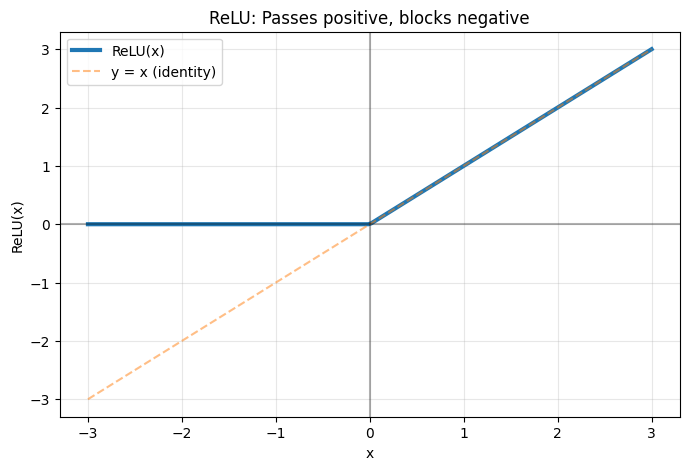

In [5]:
# Visualize ReLU
x = np.linspace(-3, 3, 200)

plt.figure(figsize=(8, 5))
plt.plot(x, np.maximum(0, x), linewidth=3, label='ReLU(x)')
plt.plot(x, x, '--', alpha=0.5, label='y = x (identity)')
plt.axhline(y=0, color='k', linestyle='-', alpha=0.3)
plt.axvline(x=0, color='k', linestyle='-', alpha=0.3)
plt.xlabel('x')
plt.ylabel('ReLU(x)')
plt.title('ReLU: Passes positive, blocks negative')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### 1.2 Why ReLU Replaced Sigmoid/Tanh

Before ReLU (around 2012), networks used sigmoid or tanh:

| Function | Formula | Range | Max Derivative |
|----------|---------|-------|----------------|
| Sigmoid | $\sigma(x) = \frac{1}{1+e^{-x}}$ | $(0, 1)$ | 0.25 |
| Tanh | $\tanh(x) = \frac{e^x - e^{-x}}{e^x + e^{-x}}$ | $(-1, 1)$ | 1.0 |
| ReLU | $\max(0, x)$ | $[0, \infty)$ | 1.0 |

**The vanishing gradient problem**:

In backpropagation, gradients multiply through layers. If each layer shrinks the gradient by a factor (like sigmoid's max 0.25), after $n$ layers:

$$\text{gradient} \propto 0.25^n \rightarrow 0$$

For a 10-layer network: $0.25^{10} \approx 0.000001$ — the gradient essentially vanishes!

ReLU's gradient is exactly **1** for positive inputs, so gradients don't shrink.

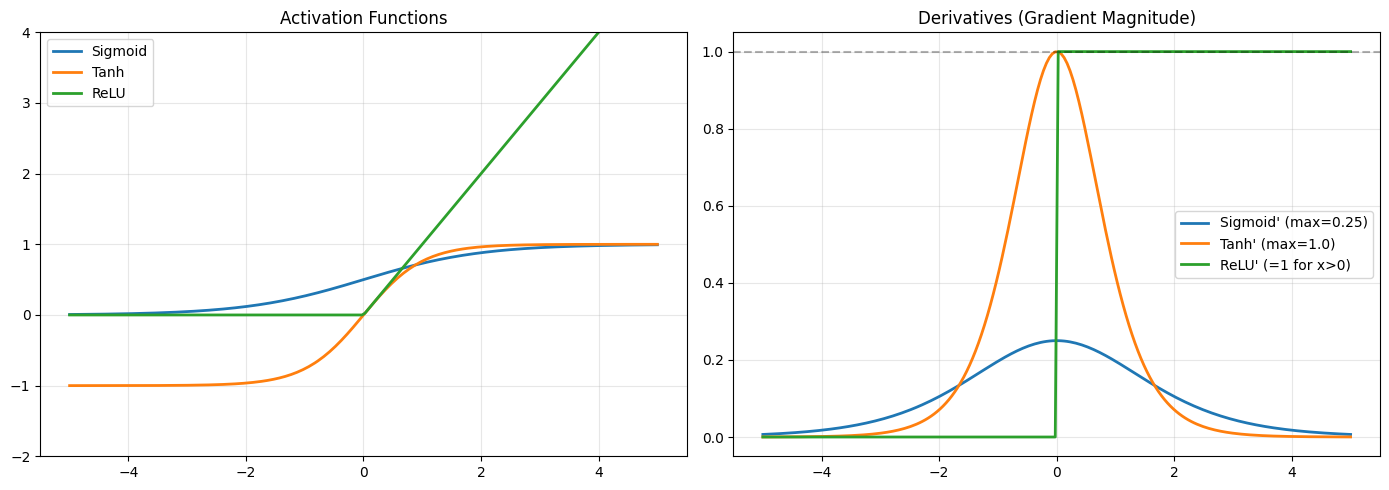

Key observation: ReLU derivative is constant 1 for x > 0
This prevents gradient vanishing in deep networks!


In [6]:
# Compare activation functions and their gradients
x = np.linspace(-5, 5, 200)

# Functions
sigmoid = 1 / (1 + np.exp(-x))
tanh_vals = np.tanh(x)
relu_vals = np.maximum(0, x)

# Derivatives
sigmoid_deriv = sigmoid * (1 - sigmoid)
tanh_deriv = 1 - tanh_vals**2
relu_deriv = (x > 0).astype(float)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(x, sigmoid, label='Sigmoid', linewidth=2)
axes[0].plot(x, tanh_vals, label='Tanh', linewidth=2)
axes[0].plot(x, relu_vals, label='ReLU', linewidth=2)
axes[0].set_title('Activation Functions')
axes[0].set_ylim(-2, 4)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(x, sigmoid_deriv, label="Sigmoid' (max=0.25)", linewidth=2)
axes[1].plot(x, tanh_deriv, label="Tanh' (max=1.0)", linewidth=2)
axes[1].plot(x, relu_deriv, label="ReLU' (=1 for x>0)", linewidth=2)
axes[1].set_title('Derivatives (Gradient Magnitude)')
axes[1].axhline(y=1, color='k', linestyle='--', alpha=0.3)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Key observation: ReLU derivative is constant 1 for x > 0")
print("This prevents gradient vanishing in deep networks!")

### 1.3 ReLU Backward Pass

**The derivative of ReLU**:

$$\frac{d}{dx}\text{ReLU}(x) = \begin{cases} 1 & \text{if } x > 0 \\ 0 & \text{if } x < 0 \end{cases}$$

At $x = 0$, ReLU has a "kink" (not differentiable). We define $\text{ReLU}'(0) = 0$ by convention.

**Implementing the backward pass**:

In backpropagation, we receive an "upstream gradient" $\frac{\partial L}{\partial y}$ (how the loss changes with respect to the output). We need to compute $\frac{\partial L}{\partial x}$ (how the loss changes with respect to the input).

By the chain rule:
$$\frac{\partial L}{\partial x} = \frac{\partial L}{\partial y} \cdot \frac{\partial y}{\partial x} = \frac{\partial L}{\partial y} \cdot \text{ReLU}'(x)$$

In code:
```python
def relu_backward(x, upstream_grad):
    return upstream_grad * (x > 0)  # Mask: 1 where x > 0, else 0
```

In [7]:
# Demonstrate ReLU backward pass step by step
x = np.array([-2.0, -0.5, 0.0, 0.5, 2.0])
upstream_grad = np.array([1.0, 1.0, 1.0, 1.0, 1.0])  # Assume gradient of 1 from above

print("Step-by-step ReLU backward:")
print(f"1. Input x:           {x}")
print(f"2. ReLU(x):           {relu(x)}")
print(f"3. Mask (x > 0):      {(x > 0).astype(float)}")
print(f"4. Upstream gradient: {upstream_grad}")
print(f"5. dx = upstream * mask: {upstream_grad * (x > 0)}")
print("\nNote: Gradient is 'blocked' where x ≤ 0")

Step-by-step ReLU backward:
1. Input x:           [-2.  -0.5  0.   0.5  2. ]
2. ReLU(x):           [0.  0.  0.  0.5 2. ]
3. Mask (x > 0):      [0. 0. 0. 1. 1.]
4. Upstream gradient: [1. 1. 1. 1. 1.]
5. dx = upstream * mask: [0. 0. 0. 1. 1.]

Note: Gradient is 'blocked' where x ≤ 0


### 1.4 The "Dying ReLU" Problem

If a neuron's weights evolve such that the input is **always negative** (for all training examples), then:
- Forward: output is always 0
- Backward: gradient is always 0
- Update: weights never change

The neuron is "dead" — it will never activate again.

**When this happens**:
- Large negative bias
- Large learning rate causing weights to overshoot
- Poor initialization

**Solutions**:
1. **Careful initialization** (He init: $\sigma = \sqrt{2/n_{\text{in}}}$)
2. **Leaky ReLU**: $f(x) = \max(0.01x, x)$ — small gradient for negative inputs
3. **GELU**: Smooth, never fully zero gradient

---
## Part 2: GELU (Gaussian Error Linear Unit)

### 2.1 The Probabilistic Intuition

GELU was introduced with a beautiful probabilistic motivation. Consider:

**Question**: What if instead of a hard threshold at 0, we randomly decided whether to keep each input, with the probability depending on how "positive" the input is?

Let's define a "stochastic ReLU":
$$\text{StochasticReLU}(x) = x \cdot m, \quad \text{where } m \sim \text{Bernoulli}(p)$$

If we set $p = \Phi(x)$ (the probability that a standard normal random variable is less than $x$), then:
- For large positive $x$: $\Phi(x) \approx 1$, so we almost always keep the input (like ReLU)
- For large negative $x$: $\Phi(x) \approx 0$, so we almost always zero it (like ReLU)
- For $x \approx 0$: $\Phi(0) = 0.5$, so we keep it with 50% probability

**GELU is the expected value of this stochastic ReLU**:

$$\text{GELU}(x) = \mathbb{E}[x \cdot m] = x \cdot \mathbb{E}[m] = x \cdot P(m = 1) = x \cdot \Phi(x)$$

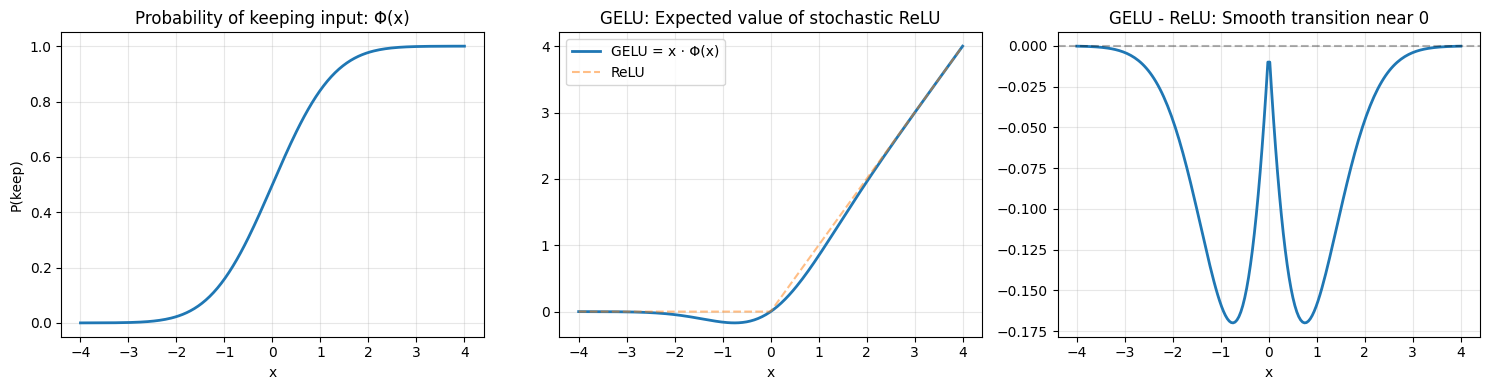

In [8]:
# Visualize the probabilistic interpretation
from scipy.stats import norm

x = np.linspace(-4, 4, 200)

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# P(keep) = Phi(x)
axes[0].plot(x, norm.cdf(x), linewidth=2)
axes[0].set_title('Probability of keeping input: Φ(x)')
axes[0].set_xlabel('x')
axes[0].set_ylabel('P(keep)')
axes[0].grid(True, alpha=0.3)

# GELU = x * Phi(x)
gelu_exact = x * norm.cdf(x)
axes[1].plot(x, gelu_exact, label='GELU = x · Φ(x)', linewidth=2)
axes[1].plot(x, np.maximum(0, x), '--', alpha=0.5, label='ReLU')
axes[1].set_title('GELU: Expected value of stochastic ReLU')
axes[1].set_xlabel('x')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Difference from ReLU
diff = gelu_exact - np.maximum(0, x)
axes[2].plot(x, diff, linewidth=2)
axes[2].axhline(y=0, color='k', linestyle='--', alpha=0.3)
axes[2].set_title('GELU - ReLU: Smooth transition near 0')
axes[2].set_xlabel('x')
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 2.2 The Exact Formula

$$\text{GELU}(x) = x \cdot \Phi(x) = x \cdot \frac{1}{2}\left[1 + \text{erf}\left(\frac{x}{\sqrt{2}}\right)\right]$$

where $\text{erf}$ is the **error function**:

$$\text{erf}(x) = \frac{2}{\sqrt{\pi}} \int_0^x e^{-t^2} dt$$

The error function doesn't have a closed-form solution — you need numerical methods or lookup tables to compute it, which is slow.

### 2.3 The Tanh Approximation

For efficiency, we use a tanh-based approximation:

$$\text{GELU}(x) \approx \frac{x}{2}\left[1 + \tanh\left(\sqrt{\frac{2}{\pi}}\left(x + 0.044715 x^3\right)\right)\right]$$

**Where does this come from?**

The error function can be approximated as:
$$\text{erf}(x) \approx \tanh\left(\sqrt{\frac{2}{\pi}} \cdot x \cdot (1 + ax^2)\right)$$

The constant $a = 0.044715$ was found by minimizing the approximation error numerically.

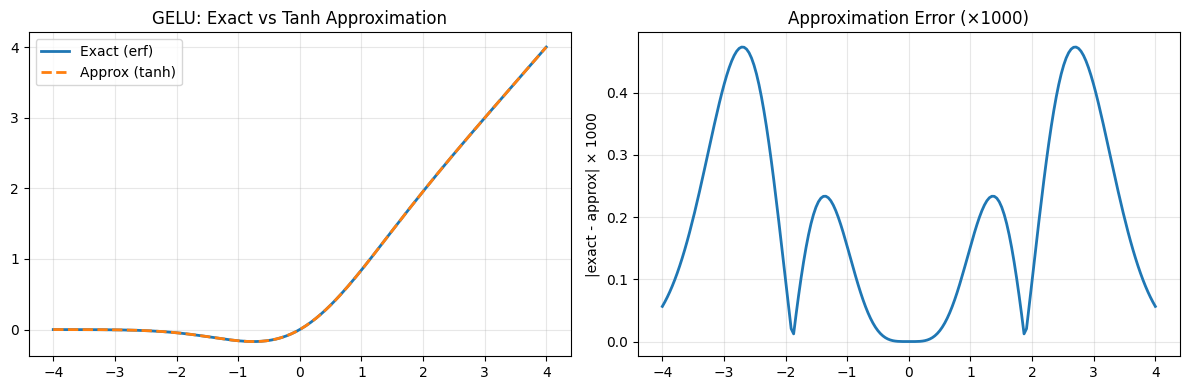

Maximum approximation error: 0.000473
This error is negligible for neural network training!


In [9]:
# Compare exact vs approximation
from scipy.special import erf

x = np.linspace(-4, 4, 200)

# Exact GELU using erf
gelu_exact = x * 0.5 * (1 + erf(x / np.sqrt(2)))

# Tanh approximation
c = np.sqrt(2 / np.pi)
gelu_approx = 0.5 * x * (1 + np.tanh(c * (x + 0.044715 * x**3)))

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(x, gelu_exact, label='Exact (erf)', linewidth=2)
axes[0].plot(x, gelu_approx, '--', label='Approx (tanh)', linewidth=2)
axes[0].legend()
axes[0].set_title('GELU: Exact vs Tanh Approximation')
axes[0].grid(True, alpha=0.3)

axes[1].plot(x, np.abs(gelu_exact - gelu_approx) * 1000, linewidth=2)
axes[1].set_title('Approximation Error (×1000)')
axes[1].set_ylabel('|exact - approx| × 1000')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Maximum approximation error: {np.abs(gelu_exact - gelu_approx).max():.6f}")
print("This error is negligible for neural network training!")

### 2.4 GELU Backward Pass Derivation

Now we derive the gradient of GELU. Let's work with the tanh approximation.

**Define intermediate variables**:
- Let $u = \sqrt{\frac{2}{\pi}}(x + 0.044715 x^3)$
- Let $t = \tanh(u)$
- Then $\text{GELU}(x) = \frac{x}{2}(1 + t)$

**Step 1: Apply the product rule**

Since $\text{GELU}(x) = \frac{x}{2} \cdot (1 + t)$, where both $\frac{x}{2}$ and $t$ depend on $x$:

$$\frac{d}{dx}\text{GELU}(x) = \frac{d}{dx}\left(\frac{x}{2}\right) \cdot (1 + t) + \frac{x}{2} \cdot \frac{d}{dx}(1 + t)$$

$$= \frac{1}{2}(1 + t) + \frac{x}{2} \cdot \frac{dt}{dx}$$

**Step 2: Find $\frac{dt}{dx}$ using chain rule**

We have $t = \tanh(u)$, so:
$$\frac{dt}{dx} = \frac{dt}{du} \cdot \frac{du}{dx}$$

We know $\frac{dt}{du} = 1 - \tanh^2(u) = 1 - t^2$ (the tanh derivative we reviewed earlier).

For $\frac{du}{dx}$, with $u = c(x + ax^3)$ where $c = \sqrt{2/\pi}$ and $a = 0.044715$:
$$\frac{du}{dx} = c(1 + 3ax^2) = \sqrt{\frac{2}{\pi}}(1 + 0.134145 x^2)$$

**Step 3: Combine everything**

$$\boxed{\text{GELU}'(x) = \frac{1}{2}(1 + t) + \frac{x}{2}(1 - t^2) \cdot \sqrt{\frac{2}{\pi}}(1 + 0.134145 x^2)}$$

where $t = \tanh\left(\sqrt{\frac{2}{\pi}}(x + 0.044715 x^3)\right)$.

In [10]:
# Implement GELU backward step by step
def gelu_backward_detailed(x):
    """GELU derivative with detailed steps."""
    # Constants
    c = np.sqrt(2.0 / np.pi)  # ≈ 0.7979
    a = 0.044715
    
    # Step 1: Compute u
    u = c * (x + a * x**3)
    print(f"u = √(2/π) · (x + 0.044715x³) = {u}")
    
    # Step 2: Compute t = tanh(u)
    t = np.tanh(u)
    print(f"t = tanh(u) = {t}")
    
    # Step 3: Compute du/dx
    du_dx = c * (1 + 3 * a * x**2)
    print(f"du/dx = √(2/π) · (1 + 0.134145x²) = {du_dx}")
    
    # Step 4: Compute dt/dx = (1 - t²) · du/dx
    dt_dx = (1 - t**2) * du_dx
    print(f"dt/dx = (1 - t²) · du/dx = {dt_dx}")
    
    # Step 5: Apply product rule
    # d/dx[x/2 · (1+t)] = 1/2 · (1+t) + x/2 · dt/dx
    term1 = 0.5 * (1 + t)
    term2 = 0.5 * x * dt_dx
    print(f"Term 1: (1/2)(1 + t) = {term1}")
    print(f"Term 2: (x/2) · dt/dx = {term2}")
    
    result = term1 + term2
    print(f"GELU'(x) = Term1 + Term2 = {result}")
    
    return result

# Test with a single value
x_test = np.array([1.0])
print("=" * 50)
print(f"Computing GELU'({x_test[0]}) step by step:")
print("=" * 50)
grad = gelu_backward_detailed(x_test)

Computing GELU'(1.0) step by step:
u = √(2/π) · (x + 0.044715x³) = [0.83356197]
t = tanh(u) = [0.68238398]
du/dx = √(2/π) · (1 + 0.134145x²) = [0.90491679]
dt/dx = (1 - t²) · du/dx = [0.48354419]
Term 1: (1/2)(1 + t) = [0.84119199]
Term 2: (x/2) · dt/dx = [0.24177209]
GELU'(x) = Term1 + Term2 = [1.08296408]


In [ ]:
# Verify with numerical gradient
def numerical_gradient(f, x, eps=1e-5):
    """Compute gradient numerically using central difference."""
    return (f(x + eps) - f(x - eps)) / (2 * eps)

def gelu_forward(x):
    c = np.sqrt(2.0 / np.pi)
    return 0.5 * x * (1.0 + np.tanh(c * (x + 0.044715 * x**3)))

def gelu_backward_formula(x):
    c = np.sqrt(2.0 / np.pi)
    u = c * (x + 0.044715 * x**3)
    t = np.tanh(u)
    du_dx = c * (1.0 + 3.0 * 0.044715 * x**2)
    return 0.5 * (1.0 + t) + 0.5 * x * (1 - t**2) * du_dx

# Test on multiple values
x_test = np.array([-2.0, -1.0, -0.5, 0.0, 0.5, 1.0, 2.0])

analytical = gelu_backward_formula(x_test)
numerical = numerical_gradient(gelu_forward, x_test)

print("Verification: Analytical vs Numerical Gradient")
print("=" * 50)
print(f"{'x':>8} {'Analytical':>12} {'Numerical':>12} {'Error':>12}")
print("-" * 50)
for i in range(len(x_test)):
    error = abs(analytical[i] - numerical[i])
    print(f"{x_test[i]:>8.1f} {analytical[i]:>12.6f} {numerical[i]:>12.6f} {error:>12.2e}")

print(f"\nMax error: {np.abs(analytical - numerical).max():.2e}")
print("✓ Our analytical gradient matches numerical gradient!")

In [ ]:
# Visualize GELU and its derivative
x = np.linspace(-4, 4, 200)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Function comparison
axes[0].plot(x, gelu_forward(x), label='GELU', linewidth=2)
axes[0].plot(x, np.maximum(0, x), '--', label='ReLU', linewidth=2, alpha=0.7)
axes[0].axhline(y=0, color='k', linestyle='-', alpha=0.2)
axes[0].axvline(x=0, color='k', linestyle='-', alpha=0.2)
axes[0].set_title('GELU vs ReLU')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Derivative comparison  
axes[1].plot(x, gelu_backward_formula(x), label="GELU'", linewidth=2)
axes[1].plot(x, (x > 0).astype(float), '--', label="ReLU'", linewidth=2, alpha=0.7)
axes[1].axhline(y=0, color='k', linestyle='-', alpha=0.2)
axes[1].axhline(y=1, color='k', linestyle='--', alpha=0.2)
axes[1].set_title('Derivatives: GELU is smooth, ReLU has discontinuity')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Key observations:")
print(f"• GELU'(-1) = {gelu_backward_formula(np.array([-1.0]))[0]:.4f} (non-zero!)")
print(f"• ReLU'(-1) = 0 (dead neuron)")
print("• GELU has smooth gradient flow everywhere")

---
## Part 3: Why GELU Works Better Than ReLU

### 3.1 No Dead Neurons

GELU's gradient is **never exactly zero**. Even for negative inputs, there's a small but non-zero gradient:

| $x$ | ReLU'($x$) | GELU'($x$) |
|-----|------------|------------|
| -3 | 0 | 0.0036 |
| -2 | 0 | 0.0183 |
| -1 | 0 | 0.0833 |
| 0 | 0 | 0.5000 |
| 1 | 1 | 0.9167 |
| 2 | 1 | 0.9820 |

This means neurons can always learn, even if they're currently outputting near-zero values.

### 3.2 Implicit Regularization

GELU can be seen as a smoothed version of dropout:
- Dropout: Randomly zero out neurons with probability $p$
- GELU: Smoothly scale neurons based on their magnitude

Both encourage the network to not rely too heavily on any single feature.

### 3.3 Better Gradient Flow

The smooth transition around zero means gradients change gradually, not abruptly. This helps optimization find better minima.

In [ ]:
# Verify our implementation matches
from ai_comps.activations import gelu, gelu_backward

x_test = np.random.randn(3, 4).astype(np.float32)

# Our implementation
y_impl = gelu(x_test)
dy_impl = gelu_backward(x_test)

# Manual computation
y_manual = gelu_forward(x_test)
dy_manual = gelu_backward_formula(x_test)

print("Verification against ai_comps implementation:")
print(f"Forward pass matches: {np.allclose(y_impl, y_manual)}")
print(f"Backward pass matches: {np.allclose(dy_impl, dy_manual)}")

---
## Summary

### ReLU
- **Forward**: $\text{ReLU}(x) = \max(0, x)$
- **Backward**: $\text{ReLU}'(x) = \mathbf{1}_{x > 0}$
- **Pros**: Fast, simple, no vanishing gradient for positive inputs
- **Cons**: Dead neurons, discontinuous gradient

### GELU
- **Forward**: $\text{GELU}(x) = \frac{x}{2}\left[1 + \tanh\left(\sqrt{\frac{2}{\pi}}(x + 0.044715x^3)\right)\right]$
- **Backward**: $\text{GELU}'(x) = \frac{1}{2}(1+t) + \frac{x}{2}(1-t^2)\sqrt{\frac{2}{\pi}}(1 + 0.134145x^2)$
- **Pros**: Smooth, no dead neurons, probabilistic interpretation
- **Cons**: ~5× more computation

### When to use which
- **ReLU**: CNNs, simple feedforward networks, when speed matters
- **GELU**: Transformers, BERT, GPT, modern language models